## Neural Network models - Leave One Participant Out CV to predict properties using 3 subwindows

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
from pandas.core.common import SettingWithCopyWarning

import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import random
import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
import torch.optim as optim



In [2]:
# Initialise the random state
#num = random.randint(1, 500)
num = 58
torch.manual_seed(num)
np.random.seed(num)
print(f"The generated random seed is {num}") #347

The generated random seed is 58


### Load data

In [3]:
import os

In [4]:
os.getcwd()

'/Users/albyscotney/Desktop/nini/2'

In [6]:
path = "complete_dataset_15subwindows_10slices.csv"
df = pd.read_csv(path)
df.head(10)

,participant_id,clothes_id,property_id,property_name,interaction_id,rating,rating_level,rating_level_num,sub_window_num,slice_num,max_ch1_hand0,max_ch2_hand0,max_ch3_hand0,max_ch4_hand0,max_ch5_hand0,max_ch6_hand0,max_ch7_hand0,max_ch8_hand0,mean_ch1_hand0,mean_ch2_hand0,mean_ch3_hand0,mean_ch4_hand0,mean_ch5_hand0,mean_ch6_hand0,mean_ch7_hand0,mean_ch8_hand0,std_ch1_hand0,std_ch2_hand0,std_ch3_hand0,std_ch4_hand0,std_ch5_hand0,std_ch6_hand0,std_ch7_hand0,std_ch8_hand0,max_ch1_hand1,max_ch2_hand1,max_ch3_hand1,max_ch4_hand1,max_ch5_hand1,max_ch6_hand1,max_ch7_hand1,max_ch8_hand1,mean_ch1_hand1,mean_ch2_hand1,mean_ch3_hand1,mean_ch4_hand1,mean_ch5_hand1,mean_ch6_hand1,mean_ch7_hand1,mean_ch8_hand1,std_ch1_hand1,std_ch2_hand1,std_ch3_hand1,std_ch4_hand1,std_ch5_hand1,std_ch6_hand1,std_ch7_hand1,std_ch8_hand1,max_Ax_hand0,max_Ay_hand0,max_Az_hand0,max_Vx_hand0,max_Vy_hand0,max_Vz_hand0,max_Jx_hand0,max_Jy_hand0,max_Jz_hand0,mean_Ax_hand0,mean_Ay_hand0,mean_Az_hand0,mean_Vx_hand0,mean_Vy_hand0,mean_Vz_hand0,mean_Jx_hand0,mean_Jy_hand0,mean_Jz_hand0,std_Ax_hand0,std_Ay_hand0,std_Az_hand0,std_Vx_hand0,std_Vy_hand0,std_Vz_hand0,std_Jx_hand0,std_Jy_hand0,std_Jz_hand0,max_Ax_hand1,max_Ay_hand1,max_Az_hand1,max_Vx_hand1,max_Vy_hand1,max_Vz_hand1,max_Jx_hand1,max_Jy_hand1,max_Jz_hand1,mean_Ax_hand1,mean_Ay_hand1,mean_Az_hand1,mean_Vx_hand1,mean_Vy_hand1,mean_Vz_hand1,mean_Jx_hand1,mean_Jy_hand1,mean_Jz_hand1,std_Ax_hand1,std_Ay_hand1,std_Az_hand1,std_Vx_hand1,std_Vy_hand1,std_Vz_hand1,std_Jx_hand1,std_Jy_hand1,std_Jz_hand1,max_w_hand0,max_x_hand0,max_y_hand0,max_z_hand0,max_AVx_hand0,max_AVy_hand0,max_AVz_hand0,max_AAx_hand0,max_AAy_hand0,max_AAz_hand0,max_AJx_hand0,max_AJy_hand0,max_AJz_hand0,mean_w_hand0,mean_x_hand0,mean_y_hand0,mean_z_hand0,mean_AVx_hand0,mean_AVy_hand0,mean_AVz_hand0,mean_AAx_hand0,mean_AAy_hand0,mean_AAz_hand0,mean_AJx_hand0,mean_AJy_hand0,mean_AJz_hand0,std_w_hand0,std_x_hand0,std_y_hand0,std_z_hand0,std_AVx_hand0,std_AVy_hand0,std_AVz_hand0,std_AAx_hand0,std_AAy_hand0,std_AAz_hand0,std_AJx_hand0,std_AJy_hand0,std_AJz_hand0,max_w_hand1,max_x_hand1,max_y_hand1,max_z_hand1,max_AVx_hand1,max_AVy_hand1,max_AVz_hand1,max_AAx_hand1,max_AAy_hand1,max_AAz_hand1,max_AJx_hand1,max_AJy_hand1,max_AJz_hand1,mean_w_hand1,mean_x_hand1,mean_y_hand1,mean_z_hand1,mean_AVx_hand1,mean_AVy_hand1,mean_AVz_hand1,mean_AAx_hand1,mean_AAy_hand1,mean_AAz_hand1,mean_AJx_hand1,mean_AJy_hand1,mean_AJz_hand1,std_w_hand1,std_x_hand1,std_y_hand1,std_z_hand1,std_AVx_hand1,std_AVy_hand1,std_AVz_hand1,std_AAx_hand1,std_AAy_hand1,std_AAz_hand1,std_AJx_hand1,std_AJy_hand1,std_AJz_hand1
0,7,14,0,smoothness,1,3,medium,2,1,1,0.500000,0.615385,0.670391,0.495868,0.759036,0.652406,0.75625,0.666667,0.497805,0.613462,0.665764,0.492188,0.718656,0.636197,0.748926,0.660851,0.002324,0.002503,0.003077,0.002455,0.006501,0.004039,0.003061,0.002083,0.508197,0.908451,0.751445,0.730159,0.493878,0.995918,0.648515,0.576037,0.496670,0.846831,0.691595,0.636244,0.491412,0.608674,0.601382,0.558852,0.004198,0.014491,0.015432,0.026432,0.002186,0.218816,0.022186,0.006429,-0.857056,-0.084885,0.479568,0.000208,0.000215,0.000349,0.718061,0.488281,1.206342,-0.863110,-0.091721,0.468826,9.082031e-06,-0.000028,-0.000006,0.036854,0.039343,0.092439,0.006753,0.007619,0.010341,0.000193,0.000245,0.000281,0.488563,0.441082,0.750762,0.986160,0.013489,-0.211105,0.001218,0.000510,0.000937,1.448006,0.708008,2.343750,0.964774,-0.007117,-0.249875,1.117188e-04,0.000070,0.000027,-0.104780,0.096063,0.335256,0.022364,0.013963,0.028878,0.000738,0.000331,0.000943,1.260192,0.571902,1.565671,0.179352,0.484946,0.160615,-0.840857,0.009831,0.012959,0.117029,1.270143,2.238883,19.812834,154.113175,104.818227,1338.775861,0.178765,0.484513,0.160469,-0.841154,-0.016003,-0.027618,-0.081836,0.129868,0.552890,-1.016133,16.779031,-45.915024,210.907738,0.000451,0.000472,0.000210,0.000335,0.016423,0.031903,0.200440,1.160057,1.546528,13.337295,97.220032,155.178181,1114.885458,0.600343,-0.175433,-0.769104,-0.129347,0.14

In [7]:
# Remove enjoyment as we are only considering physical properties
print(df.shape)
physical_df = df[df.property_name!='enjoyment']
physical_df.shape

(75588, 190)


(62989, 190)

In [8]:
physical_df.head()

,participant_id,clothes_id,property_id,property_name,interaction_id,rating,rating_level,rating_level_num,sub_window_num,slice_num,max_ch1_hand0,max_ch2_hand0,max_ch3_hand0,max_ch4_hand0,max_ch5_hand0,max_ch6_hand0,max_ch7_hand0,max_ch8_hand0,mean_ch1_hand0,mean_ch2_hand0,mean_ch3_hand0,mean_ch4_hand0,mean_ch5_hand0,mean_ch6_hand0,mean_ch7_hand0,mean_ch8_hand0,std_ch1_hand0,std_ch2_hand0,std_ch3_hand0,std_ch4_hand0,std_ch5_hand0,std_ch6_hand0,std_ch7_hand0,std_ch8_hand0,max_ch1_hand1,max_ch2_hand1,max_ch3_hand1,max_ch4_hand1,max_ch5_hand1,max_ch6_hand1,max_ch7_hand1,max_ch8_hand1,mean_ch1_hand1,mean_ch2_hand1,mean_ch3_hand1,mean_ch4_hand1,mean_ch5_hand1,mean_ch6_hand1,mean_ch7_hand1,mean_ch8_hand1,std_ch1_hand1,std_ch2_hand1,std_ch3_hand1,std_ch4_hand1,std_ch5_hand1,std_ch6_hand1,std_ch7_hand1,std_ch8_hand1,max_Ax_hand0,max_Ay_hand0,max_Az_hand0,max_Vx_hand0,max_Vy_hand0,max_Vz_hand0,max_Jx_hand0,max_Jy_hand0,max_Jz_hand0,mean_Ax_hand0,mean_Ay_hand0,mean_Az_hand0,mean_Vx_hand0,mean_Vy_hand0,mean_Vz_hand0,mean_Jx_hand0,mean_Jy_hand0,mean_Jz_hand0,std_Ax_hand0,std_Ay_hand0,std_Az_hand0,std_Vx_hand0,std_Vy_hand0,std_Vz_hand0,std_Jx_hand0,std_Jy_hand0,std_Jz_hand0,max_Ax_hand1,max_Ay_hand1,max_Az_hand1,max_Vx_hand1,max_Vy_hand1,max_Vz_hand1,max_Jx_hand1,max_Jy_hand1,max_Jz_hand1,mean_Ax_hand1,mean_Ay_hand1,mean_Az_hand1,mean_Vx_hand1,mean_Vy_hand1,mean_Vz_hand1,mean_Jx_hand1,mean_Jy_hand1,mean_Jz_hand1,std_Ax_hand1,std_Ay_hand1,std_Az_hand1,std_Vx_hand1,std_Vy_hand1,std_Vz_hand1,std_Jx_hand1,std_Jy_hand1,std_Jz_hand1,max_w_hand0,max_x_hand0,max_y_hand0,max_z_hand0,max_AVx_hand0,max_AVy_hand0,max_AVz_hand0,max_AAx_hand0,max_AAy_hand0,max_AAz_hand0,max_AJx_hand0,max_AJy_hand0,max_AJz_hand0,mean_w_hand0,mean_x_hand0,mean_y_hand0,mean_z_hand0,mean_AVx_hand0,mean_AVy_hand0,mean_AVz_hand0,mean_AAx_hand0,mean_AAy_hand0,mean_AAz_hand0,mean_AJx_hand0,mean_AJy_hand0,mean_AJz_hand0,std_w_hand0,std_x_hand0,std_y_hand0,std_z_hand0,std_AVx_hand0,std_AVy_hand0,std_AVz_hand0,std_AAx_hand0,std_AAy_hand0,std_AAz_hand0,std_AJx_hand0,std_AJy_hand0,std_AJz_hand0,max_w_hand1,max_x_hand1,max_y_hand1,max_z_hand1,max_AVx_hand1,max_AVy_hand1,max_AVz_hand1,max_AAx_hand1,max_AAy_hand1,max_AAz_hand1,max_AJx_hand1,max_AJy_hand1,max_AJz_hand1,mean_w_hand1,mean_x_hand1,mean_y_hand1,mean_z_hand1,mean_AVx_hand1,mean_AVy_hand1,mean_AVz_hand1,mean_AAx_hand1,mean_AAy_hand1,mean_AAz_hand1,mean_AJx_hand1,mean_AJy_hand1,mean_AJz_hand1,std_w_hand1,std_x_hand1,std_y_hand1,std_z_hand1,std_AVx_hand1,std_AVy_hand1,std_AVz_hand1,std_AAx_hand1,std_AAy_hand1,std_AAz_hand1,std_AJx_hand1,std_AJy_hand1,std_AJz_hand1
0,7,14,0,smoothness,1,3,medium,2,1,1,0.5,0.615385,0.670391,0.495868,0.759036,0.652406,0.75625,0.666667,0.497805,0.613462,0.665764,0.492188,0.718656,0.636197,0.748926,0.660851,0.002324,0.002503,0.003077,0.002455,0.006501,0.004039,0.003061,0.002083,0.508197,0.908451,0.751445,0.730159,0.493878,0.995918,0.648515,0.576037,0.496670,0.846831,0.691595,0.636244,0.491412,0.608674,0.601382,0.558852,0.004198,0.014491,0.015432,0.026432,0.002186,0.218816,0.022186,0.006429,-0.857056,-0.084885,0.479568,0.000208,0.000215,0.000349,0.718061,0.488281,1.206342,-0.863110,-0.091721,0.468826,9.082031e-06,-0.000028,-0.000006,0.036854,0.039343,0.092439,0.006753,0.007619,0.010341,0.000193,0.000245,0.000281,0.488563,0.441082,0.750762,0.986160,0.013489,-0.211105,0.001218,0.000510,0.000937,1.448006,0.708008,2.343750,0.964774,-0.007117,-0.249875,1.117188e-04,0.000070,0.000027,-0.104780,0.096063,0.335256,0.022364,0.013963,0.028878,0.000738,0.000331,0.000943,1.260192,0.571902,1.565671,0.179352,0.484946,0.160615,-0.840857,0.009831,0.012959,0.117029,1.270143,2.238883,19.812834,154.113175,104.818227,1338.775861,0.178765,0.484513,0.160469,-0.841154,-0.016003,-0.027618,-0.081836,0.129868,0.552890,-1.016133,16.779031,-45.915024,210.907738,0.000451,0.000472,0.000210,0.000335,0.016423,0.031903,0.200440,1.160057,1.546528,13.337295,97.220032,155.178181,1114.885458,0.600343,-0.175433,-0.769104,-0.129347,0.140072,

### Normalise the data

In [9]:
starting_index = 10
# Obtain a df of features
features_df = physical_df.iloc[:,starting_index:]
features_df.head()


,max_ch1_hand0,max_ch2_hand0,max_ch3_hand0,max_ch4_hand0,max_ch5_hand0,max_ch6_hand0,max_ch7_hand0,max_ch8_hand0,mean_ch1_hand0,mean_ch2_hand0,mean_ch3_hand0,mean_ch4_hand0,mean_ch5_hand0,mean_ch6_hand0,mean_ch7_hand0,mean_ch8_hand0,std_ch1_hand0,std_ch2_hand0,std_ch3_hand0,std_ch4_hand0,std_ch5_hand0,std_ch6_hand0,std_ch7_hand0,std_ch8_hand0,max_ch1_hand1,max_ch2_hand1,max_ch3_hand1,max_ch4_hand1,max_ch5_hand1,max_ch6_hand1,max_ch7_hand1,max_ch8_hand1,mean_ch1_hand1,mean_ch2_hand1,mean_ch3_hand1,mean_ch4_hand1,mean_ch5_hand1,mean_ch6_hand1,mean_ch7_hand1,mean_ch8_hand1,std_ch1_hand1,std_ch2_hand1,std_ch3_hand1,std_ch4_hand1,std_ch5_hand1,std_ch6_hand1,std_ch7_hand1,std_ch8_hand1,max_Ax_hand0,max_Ay_hand0,max_Az_hand0,max_Vx_hand0,max_Vy_hand0,max_Vz_hand0,max_Jx_hand0,max_Jy_hand0,max_Jz_hand0,mean_Ax_hand0,mean_Ay_hand0,mean_Az_hand0,mean_Vx_hand0,mean_Vy_hand0,mean_Vz_hand0,mean_Jx_hand0,mean_Jy_hand0,mean_Jz_hand0,std_Ax_hand0,std_Ay_hand0,std_Az_hand0,std_Vx_hand0,std_Vy_hand0,std_Vz_hand0,std_Jx_hand0,std_Jy_hand0,std_Jz_hand0,max_Ax_hand1,max_Ay_hand1,max_Az_hand1,max_Vx_hand1,max_Vy_hand1,max_Vz_hand1,max_Jx_hand1,max_Jy_hand1,max_Jz_hand1,mean_Ax_hand1,mean_Ay_hand1,mean_Az_hand1,mean_Vx_hand1,mean_Vy_hand1,mean_Vz_hand1,mean_Jx_hand1,mean_Jy_hand1,mean_Jz_hand1,std_Ax_hand1,std_Ay_hand1,std_Az_hand1,std_Vx_hand1,std_Vy_hand1,std_Vz_hand1,std_Jx_hand1,std_Jy_hand1,std_Jz_hand1,max_w_hand0,max_x_hand0,max_y_hand0,max_z_hand0,max_AVx_hand0,max_AVy_hand0,max_AVz_hand0,max_AAx_hand0,max_AAy_hand0,max_AAz_hand0,max_AJx_hand0,max_AJy_hand0,max_AJz_hand0,mean_w_hand0,mean_x_hand0,mean_y_hand0,mean_z_hand0,mean_AVx_hand0,mean_AVy_hand0,mean_AVz_hand0,mean_AAx_hand0,mean_AAy_hand0,mean_AAz_hand0,mean_AJx_hand0,mean_AJy_hand0,mean_AJz_hand0,std_w_hand0,std_x_hand0,std_y_hand0,std_z_hand0,std_AVx_hand0,std_AVy_hand0,std_AVz_hand0,std_AAx_hand0,std_AAy_hand0,std_AAz_hand0,std_AJx_hand0,std_AJy_hand0,std_AJz_hand0,max_w_hand1,max_x_hand1,max_y_hand1,max_z_hand1,max_AVx_hand1,max_AVy_hand1,max_AVz_hand1,max_AAx_hand1,max_AAy_hand1,max_AAz_hand1,max_AJx_hand1,max_AJy_hand1,max_AJz_hand1,mean_w_hand1,mean_x_hand1,mean_y_hand1,mean_z_hand1,mean_AVx_hand1,mean_AVy_hand1,mean_AVz_hand1,mean_AAx_hand1,mean_AAy_hand1,mean_AAz_hand1,mean_AJx_hand1,mean_AJy_hand1,mean_AJz_hand1,std_w_hand1,std_x_hand1,std_y_hand1,std_z_hand1,std_AVx_hand1,std_AVy_hand1,std_AVz_hand1,std_AAx_hand1,std_AAy_hand1,std_AAz_hand1,std_AJx_hand1,std_AJy_hand1,std_AJz_hand1
0,0.5,0.615385,0.670391,0.495868,0.759036,0.652406,0.75625,0.666667,0.497805,0.613462,0.665764,0.492188,0.718656,0.636197,0.748926,0.660851,0.002324,0.002503,0.003077,0.002455,0.006501,0.004039,0.003061,0.002083,0.508197,0.908451,0.751445,0.730159,0.493878,0.995918,0.648515,0.576037,0.496670,0.846831,0.691595,0.636244,0.491412,0.608674,0.601382,0.558852,0.004198,0.014491,0.015432,0.026432,0.002186,0.218816,0.022186,0.006429,-0.857056,-0.084885,0.479568,0.000208,0.000215,0.000349,0.718061,0.488281,1.206342,-0.863110,-0.091721,0.468826,9.082031e-06,-0.000028,-0.000006,0.036854,0.039343,0.092439,0.006753,0.007619,0.010341,0.000193,0.000245,0.000281,0.488563,0.441082,0.750762,0.986160,0.013489,-0.211105,0.001218,0.000510,0.000937,1.448006,0.708008,2.343750,0.964774,-0.007117,-0.249875,1.117188e-04,0.000070,0.000027,-0.104780,0.096063,0.335256,0.022364,0.013963,0.028878,0.000738,0.000331,0.000943,1.260192,0.571902,1.565671,0.179352,0.484946,0.160615,-0.840857,0.009831,0.012959,0.117029,1.270143,2.238883,19.812834,154.113175,104.818227,1338.775861,0.178765,0.484513,0.160469,-0.841154,-0.016003,-0.027618,-0.081836,0.129868,0.552890,-1.016133,16.779031,-45.915024,210.907738,0.000451,0.000472,0.000210,0.000335,0.016423,0.031903,0.200440,1.160057,1.546528,13.337295,97.220032,155.178181,1114.885458,0.600343,-0.175433,-0.769104,-0.129347,0.140072,0.440644,0.126734,5.745156,20.612016,5.331893,212.817696,779.034203,579.105295,0.598260,-0.176827,-0.770695,-0.129768,0.053843,0.125821,-0.043329,0.487977,0.515185,

In [10]:
normalised_features_df = features_df.copy()
print(normalised_features_df.shape)

(62989, 180)


In [11]:
# create scaler
scaler = MinMaxScaler(feature_range=(-1,1)) # As this is the range of the activation function - tanh

# fit scaler and apply transform
normalised_features_df[normalised_features_df.columns] = scaler.fit_transform(features_df[features_df.columns])
normalised_features_df.shape

(62989, 180)

In [12]:
df_info = physical_df.iloc[:, :starting_index]
df_info.head()

,participant_id,clothes_id,property_id,property_name,interaction_id,rating,rating_level,rating_level_num,sub_window_num,slice_num
0,7,14,0,smoothness,1,3,medium,2,1,1
1,7,14,0,smoothness,1,3,medium,2,1,2
2,7,14,0,smoothness,1,3,medium,2,1,3
3,7,14,0,smoothness,1,3,medium,2,1,4
4,7,14,0,smoothness,1,3,medium,2,1,5


In [13]:
normalised_df = pd.concat([df_info,normalised_features_df], axis=1)
normalised_df.shape

(62989, 190)

### Create X and y data

In [14]:
def create_X_2d(df, features_starting_idx):
    
    X_2d = df.iloc[:,features_starting_idx:].values
    
    X_tensor_2d = torch.Tensor(X_2d)    
    return X_tensor_2d



In [15]:
def create_y_train_for_2d_X(df, predicting_feature = 'property_id', output_as_tensor='Yes'):
    # CreatE an instance of a one-hot-encoder
    encoder = OneHotEncoder(handle_unknown='ignore')

    # Perform one-hot encoding on the specified column 
    encoder_df = pd.DataFrame(encoder.fit_transform(df[[predicting_feature]]).toarray())
    
    # Convert to a numpy array
    y_train = encoder_df.to_numpy()
    
    if output_as_tensor == 'Yes':
        # Convert to a tensor
        y_train = torch.Tensor(y_train)

    return y_train



In [16]:
def create_y_test_for_2d_X(df, predicting_feature = 'property_id'):   
    y_test = df[predicting_feature].values
    #if predicting_feature == 'property_id':
       # y_test = y_test - 3
    if predicting_feature == 'rating_level_num':
        y_test = y_test - 1
    
    y_test_tensor = torch.Tensor(y_test)    
    y_test_tensor = y_test_tensor.type(torch.LongTensor)
    
    return y_test_tensor


In [17]:
def create_X_3d(df, features_starting_idx):
    dim1 = df.new_interaction_id.nunique()
    #print(dim1)
    dim2 = df.slice_num.nunique()
    dim3 = df.iloc[:,features_starting_idx:].shape[1]
        
    X = np.zeros((dim1, dim2, dim3)) 

    itr_id_lst = df.new_interaction_id.unique().tolist()
    #print(itr_id_lst[0], itr_id_lst[-1])

    for i in range(len(itr_id_lst)): #range(len(itr_id_lst)):
        itr_id = itr_id_lst[i]
        itr_id_df = df[df.new_interaction_id==itr_id]  
        
        for j in range(itr_id_df.shape[0]):
            vals_arr = itr_id_df.iloc[j,features_starting_idx:].values

            X[i,j] = vals_arr
    
    X_tensor = torch.Tensor(X)    
    return X_tensor

In [18]:
def create_y_train_for_3d_X(df, predicting_feature = 'property_id'):
    # Create a dataset with only the required columns
    df2 = df[['new_interaction_id', 'property_id', 'rating_level_num']]

    # Remove duplicates
    df2.drop_duplicates(keep='first', inplace=True)

    # Reset the indexes
    df2.reset_index(drop=True, inplace=True) 
    
    ## Create y train
    # CreatE an instance of a one-hot-encoder
    encoder = OneHotEncoder(handle_unknown='ignore')

    # Perform one-hot encoding on the specified column 
    encoder_df = pd.DataFrame(encoder.fit_transform(df2[[predicting_feature]]).toarray())
    
    # Convert to a numpy array
    y_train = encoder_df.to_numpy()
    
    # Convert to a tensor
    y_train = torch.Tensor(y_train)
  
    return y_train



In [19]:
def create_y_test_for_3d_X(df, predicting_feature = 'property_id'):
    # Create a dataset with only the required columns
    df2 = df[['new_interaction_id', 'property_id', 'rating_level_num']]

    # Remove duplicates
    df2.drop_duplicates(keep='first', inplace=True)

    # Reset the indexes
    df2.reset_index(drop=True, inplace=True) 
    
    y_test = df2[predicting_feature].values
    #if predicting_feature == 'property_id':
       # y_test = y_test - 3
    if predicting_feature == 'rating_level_num':
        y_test = y_test - 1
    
    y_test = torch.Tensor(y_test)    
    y_test = y_test.type(torch.LongTensor)
    
    return y_test



## Model 3 - LSTM + fully connected layers using all 180 features

In [20]:
# Add a column to interact

normalised_df.insert(5, "new_interaction_id", None)
normalised_df['new_interaction_id'] = normalised_df.groupby(['participant_id', 'clothes_id', 'property_id', 'sub_window_num'], sort=False).ngroup() + 1
normalised_df.head()


,participant_id,clothes_id,property_id,property_name,interaction_id,new_interaction_id,rating,rating_level,rating_level_num,sub_window_num,slice_num,max_ch1_hand0,max_ch2_hand0,max_ch3_hand0,max_ch4_hand0,max_ch5_hand0,max_ch6_hand0,max_ch7_hand0,max_ch8_hand0,mean_ch1_hand0,mean_ch2_hand0,mean_ch3_hand0,mean_ch4_hand0,mean_ch5_hand0,mean_ch6_hand0,mean_ch7_hand0,mean_ch8_hand0,std_ch1_hand0,std_ch2_hand0,std_ch3_hand0,std_ch4_hand0,std_ch5_hand0,std_ch6_hand0,std_ch7_hand0,std_ch8_hand0,max_ch1_hand1,max_ch2_hand1,max_ch3_hand1,max_ch4_hand1,max_ch5_hand1,max_ch6_hand1,max_ch7_hand1,max_ch8_hand1,mean_ch1_hand1,mean_ch2_hand1,mean_ch3_hand1,mean_ch4_hand1,mean_ch5_hand1,mean_ch6_hand1,mean_ch7_hand1,mean_ch8_hand1,std_ch1_hand1,std_ch2_hand1,std_ch3_hand1,std_ch4_hand1,std_ch5_hand1,std_ch6_hand1,std_ch7_hand1,std_ch8_hand1,max_Ax_hand0,max_Ay_hand0,max_Az_hand0,max_Vx_hand0,max_Vy_hand0,max_Vz_hand0,max_Jx_hand0,max_Jy_hand0,max_Jz_hand0,mean_Ax_hand0,mean_Ay_hand0,mean_Az_hand0,mean_Vx_hand0,mean_Vy_hand0,mean_Vz_hand0,mean_Jx_hand0,mean_Jy_hand0,mean_Jz_hand0,std_Ax_hand0,std_Ay_hand0,std_Az_hand0,std_Vx_hand0,std_Vy_hand0,std_Vz_hand0,std_Jx_hand0,std_Jy_hand0,std_Jz_hand0,max_Ax_hand1,max_Ay_hand1,max_Az_hand1,max_Vx_hand1,max_Vy_hand1,max_Vz_hand1,max_Jx_hand1,max_Jy_hand1,max_Jz_hand1,mean_Ax_hand1,mean_Ay_hand1,mean_Az_hand1,mean_Vx_hand1,mean_Vy_hand1,mean_Vz_hand1,mean_Jx_hand1,mean_Jy_hand1,mean_Jz_hand1,std_Ax_hand1,std_Ay_hand1,std_Az_hand1,std_Vx_hand1,std_Vy_hand1,std_Vz_hand1,std_Jx_hand1,std_Jy_hand1,std_Jz_hand1,max_w_hand0,max_x_hand0,max_y_hand0,max_z_hand0,max_AVx_hand0,max_AVy_hand0,max_AVz_hand0,max_AAx_hand0,max_AAy_hand0,max_AAz_hand0,max_AJx_hand0,max_AJy_hand0,max_AJz_hand0,mean_w_hand0,mean_x_hand0,mean_y_hand0,mean_z_hand0,mean_AVx_hand0,mean_AVy_hand0,mean_AVz_hand0,mean_AAx_hand0,mean_AAy_hand0,mean_AAz_hand0,mean_AJx_hand0,mean_AJy_hand0,mean_AJz_hand0,std_w_hand0,std_x_hand0,std_y_hand0,std_z_hand0,std_AVx_hand0,std_AVy_hand0,std_AVz_hand0,std_AAx_hand0,std_AAy_hand0,std_AAz_hand0,std_AJx_hand0,std_AJy_hand0,std_AJz_hand0,max_w_hand1,max_x_hand1,max_y_hand1,max_z_hand1,max_AVx_hand1,max_AVy_hand1,max_AVz_hand1,max_AAx_hand1,max_AAy_hand1,max_AAz_hand1,max_AJx_hand1,max_AJy_hand1,max_AJz_hand1,mean_w_hand1,mean_x_hand1,mean_y_hand1,mean_z_hand1,mean_AVx_hand1,mean_AVy_hand1,mean_AVz_hand1,mean_AAx_hand1,mean_AAy_hand1,mean_AAz_hand1,mean_AJx_hand1,mean_AJy_hand1,mean_AJz_hand1,std_w_hand1,std_x_hand1,std_y_hand1,std_z_hand1,std_AVx_hand1,std_AVy_hand1,std_AVz_hand1,std_AAx_hand1,std_AAy_hand1,std_AAz_hand1,std_AJx_hand1,std_AJy_hand1,std_AJz_hand1
0,7,14,0,smoothness,1,1,3,medium,2,1,1,0.0,0.230770,0.340782,-0.008264,0.518072,0.304812,0.5125,0.333334,0.105622,0.455254,0.577297,0.056875,0.446129,0.303102,0.943664,0.564435,-0.990521,-0.981855,-0.984801,-0.989275,-0.973135,-0.981379,-0.984702,-0.988480,0.016394,0.816902,0.502890,0.460318,-0.012244,0.991836,0.297030,0.152074,0.174747,0.985894,0.736662,0.684659,0.018955,0.235310,0.446184,0.297088,-0.978337,-0.932686,-0.807487,-0.845116,-0.991154,-0.024696,-0.856611,-0.968329,-0.728124,-0.416482,-0.010119,-0.197116,-0.585083,-0.337288,-0.860287,-0.910748,-0.952013,-0.545691,-0.244773,0.436088,0.200672,0.069819,-0.060762,-0.015518,-0.065621,0.011438,-0.990459,-0.993401,-0.986621,-0.993831,-0.996108,-0.993498,-0.991505,-0.993464,-0.992197,0.029807,-0.319064,-0.467255,-0.992584,-0.632965,-0.350807,-0.923586,-0.939622,-0.823773,0.226503,-0.096807,-0.147231,-0.963721,0.939540,0.881699,-0.367810,0.139792,-0.172540,-0.965558,-0.985196,-0.958584,-0.999301,-0.999391,-0.998749,-0.985478,-0.992713,-0.974224,0.123122,0.549877,0.175362,-0.876393,-0.418991,-0.545758,-0.743598,-0.887435,-0.942242,-0.661832,-0.977063,-0.975930,-0.984503,0.123921,0.558931,0.177193,-0.876188,-0.407634,-0.124852,-0.230323,0.204814,-0.854447,-0.005374,-0.005673,-0.728135,-0.342088,-0.988791,-0.986034,-0.994257,-0.991705,-0.997799,-0.997269,-0.987286,-0.998617,-0.997923,-0.987446,-0.9994

In [21]:
# Obtain features for each hand
hand1_emg = normalised_df.iloc[:,35:59]

hand0_acc = normalised_df.iloc[:,59:86]
hand1_acc = normalised_df.iloc[:,86:113]

hand0_qua = normalised_df.iloc[:,113:152]
hand1_qua = normalised_df.iloc[:,152:]

df_info = normalised_df.iloc[:,:11]

# Combine the data to ceate a df for each hand
emg_0 = normalised_df.iloc[:,:35]
emg_1 = pd.concat([df_info, hand1_emg], axis=1)

hand_0 = pd.concat([emg_0, hand0_acc, hand0_qua], axis=1)
hand_1 = pd.concat([df_info, hand1_emg, hand1_acc, hand1_qua], axis=1)

In [22]:
print(hand_0.shape)
print(hand_1.shape)

print(emg_0.shape)
print(emg_1.shape)


(62989, 101)
(62989, 101)
(62989, 35)
(62989, 35)


### Create the model

In [32]:
class LSTM_all_features_properties(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(90, 40, 1, batch_first=True)
        self.fc1 = nn.Linear(10 * 40 * 2, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 5)
          
    def forward(self, x1, x2): #, x2
        #print(x1.shape)
        x1, (hn, cn) = self.rnn(x1) #, (self.h0, self.c0)
        x1 = F.tanh(x1)
        #print(x2.shape)
        x2, (hm, cm) = self.rnn(x2) # (self.h0, self.c0)
        x2 = F.tanh(x2)
        #print(x1.shape,x2.shape)
        x = torch.cat((x1, x2), 2)
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x
    
class LSTM_all_features_ratings(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(90+5, 40, 1, batch_first=True)
        self.fc1 = nn.Linear(10 * 40 * 2, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 3)
          
    def forward(self, x1, x2): #, x2
        x1, (hn, cn) = self.rnn(x1) #, (self.h0, self.c0)
        x1 = F.tanh(x1)
        x2, (hm, cm) = self.rnn(x2) # (self.h0, self.c0)
        x2 = F.tanh(x2)
        
        x = torch.cat((x1, x2), 2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x
    


In [33]:
def find_best_model_for_3d_X(train_dataloader, val_dataloader, learning_rate, num_epochs, model):

    # Model
    train_model = model

    # Loss and Optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(train_model.parameters(), lr=learning_rate, momentum=0.7)

    best_avg_loss = np.inf
    best_model = None
    #best_model_epoch_num = np.inf
    train_loss_lst = []
    val_loss_lst = []
    avg_loss_lst = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        #Set the model in training mode
        train_model.train()

        # Initialise the total training and validation loss
        epoch_train_loss = 0
        epoch_val_loss = 0
        avg_loss = 0

        #running_loss = 0.0
        for i, train_data in enumerate(train_dataloader, 0):
            #print(len(train_data))

            # get the inputs; data is a list of [input1, input2, label]
            train_input1, train_input2, train_labels = train_data #train_input2, 

            #train_labels = train_labels.type(torch.LongTensor)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_preds = train_model(train_input1, train_input2)  
            #print(train_labels)#

            train_loss = criterion(train_preds, train_labels)
            train_loss.backward()
            optimizer.step()

            # Update training loss
            epoch_train_loss += train_loss.item()

        # Switch off auto grad for evaluation
        with torch.no_grad():

            # Set the model in evaluation mode
            train_model.eval()

            for j, val_data in enumerate(val_dataloader, 0):
               # print(len(val_data))
            # get the inputs; data is a list of [input1, input2, label]
                val_input1, val_input2, val_labels = val_data # val_input2, 

                #val_labels = val_labels.type(torch.LongTensor)

                val_preds = train_model(val_input1, val_input2) #, val_input2

                # Update validation loss
                val_loss = criterion(val_preds, val_labels)

                epoch_val_loss += val_loss.item()
     
        avg_training_loss = epoch_train_loss / len(train_dataloader) #count_train
        avg_validation_loss = epoch_val_loss / len(val_dataloader) #count_val
        avg_loss = (avg_training_loss + avg_validation_loss) / 2
        
        train_loss_lst.append(avg_training_loss)
        val_loss_lst.append(avg_validation_loss)
        avg_loss_lst.append(avg_loss)
         
        print(f'epoch {epoch+1}: train loss = {round(avg_training_loss,3)}, val loss = {round(avg_validation_loss,3)}, average loss = {round(avg_loss,3)}')

        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            best_model = train_model.state_dict()

    return best_avg_loss, best_model, train_loss_lst, val_loss_lst, avg_loss_lst   #, avg_loss_lst, 


In [34]:
# Original
def LSTM_LOP0CV(data_0, data_1, model, num_folds=5, predicting_feature='property_id', learning_rate=0.01, num_epochs=10, random_state=num): #, num_inner_folds=5
    # Set fixed random number seed
    torch.manual_seed(num)
        
    total_conf_mat = 0
    micro_f1_lst = []
    acc_lst = []
    if predicting_feature == 'property_id':
        macro_f1_lst = []
    elif predicting_feature == 'rating_level_num':
        weighted_f1_lst = [] 
        
        data0_add = create_y_train_for_2d_X(data_0, predicting_feature = 'property_id', output_as_tensor='No')
        data0_add_pd = pd.DataFrame(data0_add, columns = ['smoothness','thickness','warmth', 'flexibility', 'softness'])
        data_0 = pd.concat([data_0.reset_index(drop=True), data0_add_pd.reset_index(drop=True)], axis=1)
        data1_add = create_y_train_for_2d_X(data_1, predicting_feature = 'property_id', output_as_tensor='No')
        data1_add_pd = pd.DataFrame(data1_add, columns = ['smoothness','thickness','warmth', 'flexibility', 'softness'])
        data_1 = pd.concat([data_1.reset_index(drop=True), data1_add_pd.reset_index(drop=True)], axis=1)
    
    for participant in sorted(data_0.participant_id.unique()): # # #:lst: #
        print(f'LEAVING PARTICIPANT {participant} OUT:')
        
        # Split the data into training and testing
        training_data_0 = data_0[data_0.participant_id != participant] 
        training_data_1 = data_1[data_1.participant_id != participant] 
        testing_data_0 = data_0[data_0.participant_id == participant] 
        testing_data_1 = data_1[data_1.participant_id == participant] 

        # Data preparation
        X_train_0 = create_X_3d(training_data_0, 11)
        X_train_1 = create_X_3d(training_data_1, 11) 
        X_test_0 = create_X_3d(testing_data_0, 11) 
        X_test_1 = create_X_3d(testing_data_1, 11)           
        y_train = create_y_train_for_3d_X(training_data_0, predicting_feature = predicting_feature)
        y_test = create_y_test_for_3d_X(testing_data_0, predicting_feature = predicting_feature)        
 

        #print(X_train_0.shape)
        #print(X_train_1.shape)
        #print(y_train.shape)
        #print(X_test_0.shape)
        #print(X_test_1.shape)
        #print(y_test.shape)
 
        # Create the datasets and dataloaders
        train_dataset = TensorDataset(X_train_0, X_train_1, y_train) 
        
        test_dataset = TensorDataset(X_test_0, X_test_1, y_test)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=y_test.shape[0]//4) # num_workers=2,       
            
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_folds, shuffle=True, random_state=num)
                
        min_avg_loss_subject = np.inf
        best_model_subject = None
        
        best_train_loss_lst = None
        best_val_loss_lst = None
        best_avg_loss_lst = None
        best_fold = np.inf

        for fold, (train_ids, val_ids) in enumerate(cv_inner.split(train_dataset)):
            print(f'FOLD {fold+1}:')
                       
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids) # The ids are the same for both
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

            # Define data loaders for training and testing data in this fold
            train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler) #, batch_size=100
            val_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=val_subsampler) #, batch_size=20        

            avg_loss_fold, best_model_fold, fold_train_loss_lst, fold_val_loss_lst, fold_avg_loss_lst = find_best_model_for_3d_X(train_dataloader, val_dataloader, learning_rate, num_epochs, model)
                           
            if avg_loss_fold < min_avg_loss_subject:
                min_avg_loss_subject = avg_loss_fold
                best_model_subject = best_model_fold
                best_train_loss_lst = fold_train_loss_lst
                best_val_loss_lst = fold_val_loss_lst
                best_avg_loss_lst = fold_avg_loss_lst
                best_fold = fold+1

        fig = plt.figure(f"{participant}")                  
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_train_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_val_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_avg_loss_lst)
        plt.title(f"Loss when participant {participant} is left out for fold {best_fold} (lr={learning_rate}, num_epochs ={num_epochs})")
        plt.legend(['train loss', 'val loss', 'avg_loss'])

        # save trained model 
        name = 'model_participant_'+str(participant)+'.pt'
        torch.save(best_model_subject, name)
        print(f'The model for participant {participant} has been saved')
        
        test_model = model
        test_model.load_state_dict(torch.load(name))

        dataiter = iter(test_dataloader) 
        test_input1, test_input2, test_labels = dataiter.next() 
    
        test_preds = test_model(test_input1, test_input2) 
        
        test_preds_np = test_preds.detach().numpy()
        test_predicted_np = np.argmax(test_preds_np, axis = 1)
        
        test_labels_np = test_labels.numpy()    
        
        if predicting_feature == 'property_id':
            conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0, 1, 2, 3, 4])
            macro_f1_score = f1_score(test_labels_np, test_predicted_np, average='macro') 
            macro_f1_lst.append(macro_f1_score) 
        elif predicting_feature == 'rating_level_num':
            conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0,1,2])
            weighted_f1_score = f1_score(test_labels_np, test_predicted_np, average='weighted') 
            weighted_f1_lst.append(weighted_f1_score)
            
        total_conf_mat += conf_mat
        micro_f1_score = f1_score(test_labels_np, test_predicted_np, average='micro')  
        micro_f1_lst.append(micro_f1_score)
        acc = accuracy_score(test_labels_np, test_predicted_np)
        acc_lst.append(acc)


        print(f"Leaving participant {participant} out")
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) micro F1 score = {round(micro_f1_score,2)}")
        if predicting_feature == 'property_id':
            print(f"(3) Macro F1 score = {round(macro_f1_score,2)}")
        elif predicting_feature == 'rating_level_num':
            print(f"(3) Weighted F1 score = {round(weighted_f1_score,2)}")            
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")
        
        total_conf_mat += conf_mat 
        micro_f1_lst.append(micro_f1_score)
        acc_lst.append(acc)
        print('--------------------------------')
        
    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    if predicting_feature == 'property_id':
        avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)  
    elif predicting_feature == 'rating_level_num':
        avg_weighted_f1_score = sum(weighted_f1_lst) / len(weighted_f1_lst)             
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Participant Out CV (LOPOCV):') 
    print("(1) Confusion matrix:\n", total_conf_mat)
    print(f"(2) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    if predicting_feature == 'property_id':
        print(f"(3) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    elif predicting_feature == 'rating_level_num':
        print(f"(3) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(4) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")
            


### Run the model for properties

In [ ]:
LSTM_LOP0CV(hand_0, hand_1, model=LSTM_all_features_properties(), num_folds=5, predicting_feature='property_id', learning_rate=0.005, num_epochs=50, random_state=num) #, num_inner_folds=5


LEAVING PARTICIPANT 1 OUT:
FOLD 1:
epoch 1: train loss = 1.611, val loss = 1.609, average loss = 1.61
epoch 2: train loss = 1.608, val loss = 1.608, average loss = 1.608
epoch 3: train loss = 1.6, val loss = 1.585, average loss = 1.592
epoch 4: train loss = 1.587, val loss = 1.614, average loss = 1.6
epoch 5: train loss = 1.575, val loss = 1.571, average loss = 1.573
epoch 6: train loss = 1.567, val loss = 1.548, average loss = 1.558
epoch 7: train loss = 1.557, val loss = 1.559, average loss = 1.558
epoch 8: train loss = 1.548, val loss = 1.587, average loss = 1.568
epoch 9: train loss = 1.545, val loss = 1.555, average loss = 1.55
epoch 10: train loss = 1.544, val loss = 1.537, average loss = 1.541
epoch 11: train loss = 1.534, val loss = 1.543, average loss = 1.539
epoch 12: train loss = 1.524, val loss = 1.535, average loss = 1.529
epoch 13: train loss = 1.528, val loss = 1.554, average loss = 1.541
epoch 14: train loss = 1.53, val loss = 1.526, average loss = 1.528
epoch 15: train

### Run the model for ratings

LEAVING PARTICIPANT 1 OUT:
FOLD 1:
epoch 1: train loss = 1.036, val loss = 1.027, average loss = 1.031
epoch 2: train loss = 1.021, val loss = 1.004, average loss = 1.013
epoch 3: train loss = 0.999, val loss = 0.994, average loss = 0.997
epoch 4: train loss = 0.986, val loss = 0.977, average loss = 0.982
epoch 5: train loss = 0.974, val loss = 0.963, average loss = 0.969
epoch 6: train loss = 0.959, val loss = 0.958, average loss = 0.959
epoch 7: train loss = 0.96, val loss = 0.965, average loss = 0.962
epoch 8: train loss = 0.957, val loss = 0.943, average loss = 0.95
epoch 9: train loss = 0.946, val loss = 1.122, average loss = 1.034
epoch 10: train loss = 0.934, val loss = 0.932, average loss = 0.933
epoch 11: train loss = 0.929, val loss = 0.921, average loss = 0.925
epoch 12: train loss = 0.919, val loss = 0.936, average loss = 0.928
epoch 13: train loss = 0.924, val loss = 0.919, average loss = 0.921
epoch 14: train loss = 0.923, val loss = 0.95, average loss = 0.937
epoch 15: t

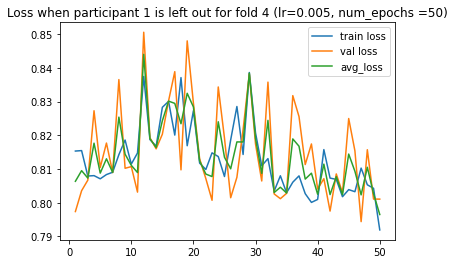

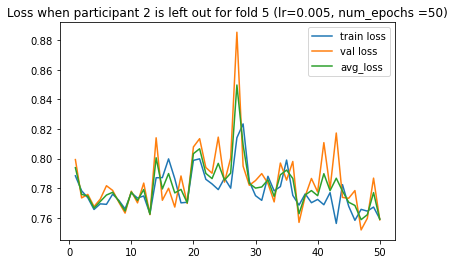

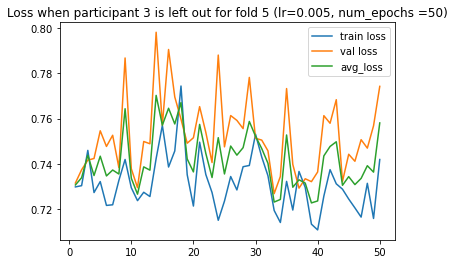

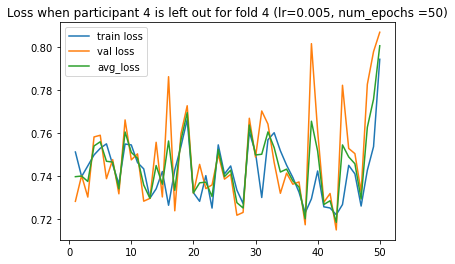

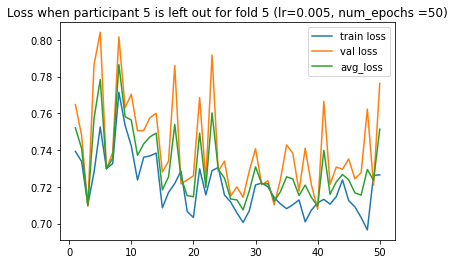

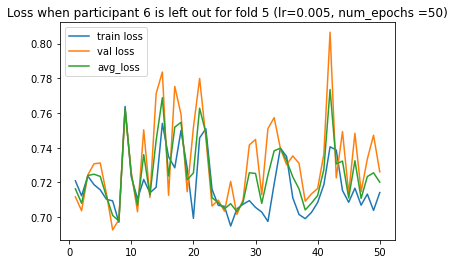

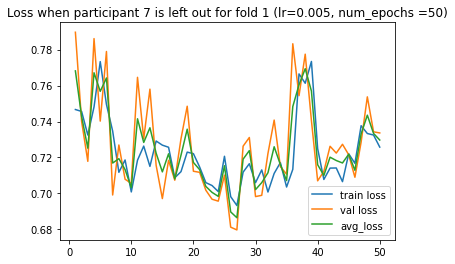

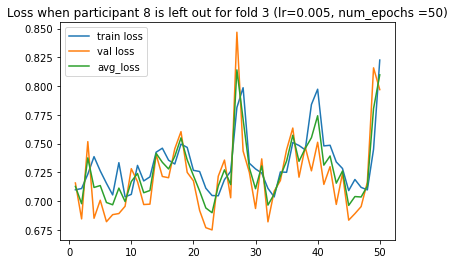

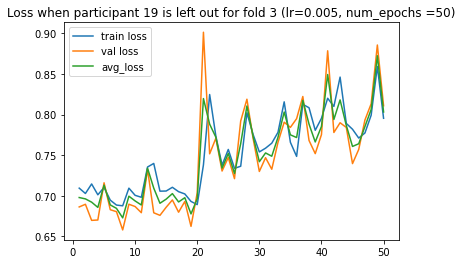

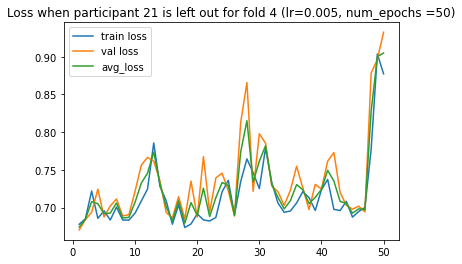

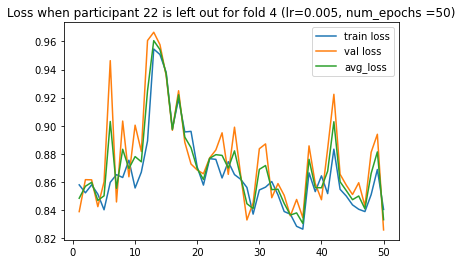

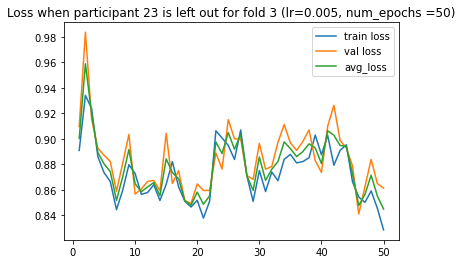

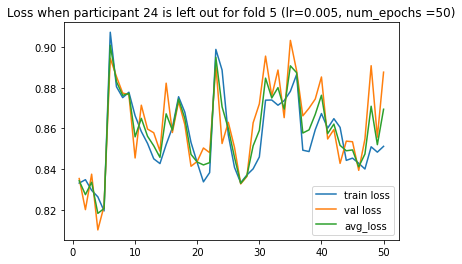

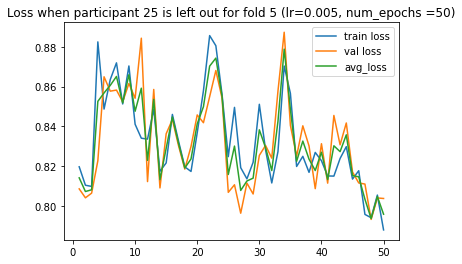

In [38]:
LSTM_LOP0CV(hand_0, hand_1, model=LSTM_all_features_ratings(), num_folds=5, predicting_feature='rating_level_num', learning_rate=0.005, num_epochs=50, random_state=num) #, num_inner_folds=5


## Model 4 - LSTM + fully connected layers using only the emg data (48 features)

complete_emg = normalised_df.iloc[:,:59]
hand0_emg = normalised_df.iloc[:,35:59]
hand0_emg.head()

#hand0_emg = normalised_df.iloc[:,19:27]
hand1_emg = normalised_df.iloc[:,35:59]

emg_0 = normalised_df.iloc[:,:35]
emg_1 = pd.concat([df_info, hand1_emg], axis=1)


### Create the model

In [39]:
class LSTM_emg_features_properties(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(24, 15, 1, batch_first=True)
        self.fc1 = nn.Linear(3 * 15 * 2, 25)
        self.fc2 = nn.Linear(25, 10)
        self.fc3 = nn.Linear(10, 5)
          
    def forward(self, x1, x2): #, x2
        x1, (hn, cn) = self.rnn(x1) #, (self.h0, self.c0)
        x1 = F.tanh(x1)
        x2, (hm, cm) = self.rnn(x2) # (self.h0, self.c0)
        x2 = F.tanh(x2)
        
        x = torch.cat((x1, x2), 2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x
    
class LSTM_emg_features_ratings(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(24+5, 15, 1, batch_first=True)
        self.fc1 = nn.Linear(3 * 15 * 2, 25)
        self.fc2 = nn.Linear(25, 10)
        self.fc3 = nn.Linear(10, 3)
          
    def forward(self, x1, x2): #, x2
        x1, (hn, cn) = self.rnn(x1) #, (self.h0, self.c0)
        x1 = F.tanh(x1)
        x2, (hm, cm) = self.rnn(x2) # (self.h0, self.c0)
        x2 = F.tanh(x2)
        
        x = torch.cat((x1, x2), 2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

### Run the model

In [40]:
LSTM_LOP0CV(emg_0, emg_1, model=LSTM_emg_features_properties(), num_folds=5, predicting_feature='property_id', learning_rate=0.005, num_epochs=70, random_state=num) #, num_inner_folds=5



LEAVING PARTICIPANT 1 OUT:
FOLD 1:


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x300 and 90x25)

### Run the model for ratings

In [ ]:
LSTM_LOP0CV(emg_0, emg_1, model=LSTM_emg_features_ratings(), num_folds=5, predicting_feature='rating_level_num', learning_rate=0.005, num_epochs=50, random_state=num) #, num_inner_folds=5


In [ ]:
dtryftugyihuoi

In [ ]:
def find_best_model_for_fold_4(train_dataloader, val_dataloader, learning_rate, num_epochs):

    # Model
    train_model = LSTM_2()

    # Loss and Optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(train_model.parameters(), lr=learning_rate, momentum=0.7)

    best_avg_loss = np.inf
    best_model = None
    #best_model_epoch_num = np.inf
    train_loss_lst = []
    val_loss_lst = []
    avg_loss_lst = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        #Set the model in training mode
        train_model.train()

        # Initialise the total training and validation loss
        epoch_train_loss = 0
        epoch_val_loss = 0
        avg_loss = 0
        #count_train = 0
        #count_val = 0

        #running_loss = 0.0
        for i, train_data in enumerate(train_dataloader, 0):
            #print(len(train_data))
            #count_train += 1
            # get the inputs; data is a list of [input1, input2, label]
            train_input1, train_input2, train_labels = train_data #train_input2, 

            #train_labels = train_labels.type(torch.LongTensor)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_preds = train_model(train_input1, train_input2)  
            #print(train_labels)#

            train_loss = criterion(train_preds, train_labels)
            train_loss.backward()
            optimizer.step()

            # Update training loss
            epoch_train_loss += train_loss.item()

        # Switch off auto grad for evaluation
        with torch.no_grad():

            # Set the model in evaluation mode
            train_model.eval()

            for j, val_data in enumerate(val_dataloader, 0):
               # count_val += 1
               # print(len(val_data))
            # get the inputs; data is a list of [input1, input2, label]
                val_input1, val_input2, val_labels = val_data # val_input2, 

                #val_labels = val_labels.type(torch.LongTensor)

                val_preds = train_model(val_input1, val_input2) #, val_input2

                # Update validation loss
                val_loss = criterion(val_preds, val_labels)

                epoch_val_loss += val_loss.item()
        #print(len(train_dataloader), len(val_dataloader))       
        avg_training_loss = epoch_train_loss / len(train_dataloader) #count_train
        avg_validation_loss = epoch_val_loss / len(val_dataloader) #count_val
        avg_loss = (avg_training_loss + avg_validation_loss) / 2
        
        train_loss_lst.append(avg_training_loss)
        val_loss_lst.append(avg_validation_loss)
        avg_loss_lst.append(avg_loss)
         
        #print(f'epoch {epoch+1}: train loss = {round(avg_training_loss,2)}, val loss = {round(avg_validation_loss,2)}, average loss = {round(avg_loss,2)}')

        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            best_model = train_model.state_dict()

    return best_avg_loss, best_model, train_loss_lst, val_loss_lst, avg_loss_lst   #, avg_loss_lst, 


In [ ]:
# Original
def LSTM_LOP0CV_properties_2(data_0, data_1, num_folds=5, predicting_feature='property_id', learning_rate=0.01, num_epochs=10, random_state=num): #, num_inner_folds=5
    # Set fixed random number seed
    torch.manual_seed(num)
    
   # elif predicting_feature == 'rating_level_num':
    #weighted_f1_lst = [] 
    total_conf_mat = 0
    micro_f1_lst = []
    macro_f1_lst = []
    acc_lst = []

    #lst = [6,24,2]#,24]
    
    for participant in sorted(data_0.participant_id.unique()): # #:lst: #
        print(f'LEAVING PARTICIPANT {participant} OUT:')
        
        # Split the data into training and testing
        training_data_0 = data_0[data_0.participant_id != participant] 
        training_data_1 = data_1[data_1.participant_id != participant] 
        testing_data_0 = data_0[data_0.participant_id == participant] 
        testing_data_1 = data_1[data_1.participant_id == participant] 

        # Data preparation
        X_train_0 = create_X_3d(training_data_0, 11)
        X_train_1 = create_X_3d(training_data_1, 11)        
        y_train = create_y_train_for_3d_X(training_data_0, predicting_feature = 'property_id')
        X_test_0 = create_X_3d(testing_data_0, 11) 
        X_test_1 = create_X_3d(testing_data_1, 11)
        y_test = create_y_test_for_3d_X(testing_data_0, predicting_feature = 'property_id')
        #print(y_test)

        #print(X_train_0.shape)
        #print(X_train_1.shape)
        #print(y_train.shape)
        #print(X_test_0.shape)
        #print(X_test_1.shape)
        #print(y_test.shape)
 
        # Create the datasets and dataloaders
        train_dataset = TensorDataset(X_train_0, X_train_1, y_train) 
        
        test_dataset = TensorDataset(X_test_0, X_test_1, y_test)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=30) # num_workers=2,       
            
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_folds, shuffle=True, random_state=num)
                
        min_avg_loss_subject = np.inf
        best_model_subject = None
        
        best_train_loss_lst = None
        best_val_loss_lst = None
        best_avg_loss_lst = None
        best_fold = np.inf

        for fold, (train_ids, val_ids) in enumerate(cv_inner.split(train_dataset)):
            #print(f'FOLD {fold+1}:')
                       
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids) # The ids are the same for both
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

            # Define data loaders for training and testing data in this fold
            train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler) #, batch_size=100
            val_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=val_subsampler) #, batch_size=20        

            avg_loss_fold, best_model_fold, fold_train_loss_lst, fold_val_loss_lst, fold_avg_loss_lst = find_best_model_for_fold_4(train_dataloader, val_dataloader, learning_rate, num_epochs)
                           
            if avg_loss_fold < min_avg_loss_subject:
                min_avg_loss_subject = avg_loss_fold
                best_model_subject = best_model_fold
                best_train_loss_lst = fold_train_loss_lst
                best_val_loss_lst = fold_val_loss_lst
                best_avg_loss_lst = fold_avg_loss_lst
                best_fold = fold+1

        fig = plt.figure(f"{participant}")                  
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_train_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_val_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_avg_loss_lst)
        plt.title(f"Loss when participant {participant} is left out for fold {best_fold} (lr={learning_rate}, num_epochs ={num_epochs})")
        plt.legend(['train loss', 'val loss', 'avg_loss'])

        # save trained model 
        name = 'model_participant_'+str(participant)+'.pt'
        torch.save(best_model_subject, name)
        print(f'The model for participant {participant} has been saved')
        
        test_model = LSTM_2()
        test_model.load_state_dict(torch.load(name))

        dataiter = iter(test_dataloader) 
        test_input1, test_input2, test_labels = dataiter.next() 
    
        test_preds = test_model(test_input1, test_input2) 
        
        test_preds_np = test_preds.detach().numpy()
        test_predicted_np = np.argmax(test_preds_np, axis = 1)
        
        test_labels_np = test_labels.numpy()       
        

        conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0, 1, 2, 3, 4])
        macro_f1_score = f1_score(test_labels_np, test_predicted_np, average='macro') 
        micro_f1_score = f1_score(test_labels_np, test_predicted_np, average='micro')  
        acc = accuracy_score(test_labels_np, test_predicted_np)

        print(f"Leaving participant {participant} out")
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) micro F1 score = {round(micro_f1_score,2)}")
        print(f"(3) macro F1 score = {round(macro_f1_score,2)}")    
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")
        
        total_conf_mat += conf_mat 
        micro_f1_lst.append(micro_f1_score)
        macro_f1_lst.append(macro_f1_score) 
        acc_lst.append(acc)
        print('--------------------------------')
        
    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)         
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Participant Out CV (LOPOCV):') 
    print("(1) Confusion matrix:\n", total_conf_mat)
    print(f"(2) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    #if predicting_feature == 'property_id':
    print(f"(3) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    #elif predicting_feature == 'rating_level_num':
        #print(f"(3) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(4) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")
            



In [ ]:
LSTM_LOP0CV_properties_2(emg_0, emg_1, num_folds=5, predicting_feature='property_id', learning_rate=0.05, num_epochs=70, random_state=num) 


In [ ]:
t2 = time.time()

## Model 5 - CNN + LSTM

In [ ]:
complete_emg = normalised_df.iloc[:,:59]
hand0_emg = normalised_df.iloc[:,43:51]
hand0_emg.head()

In [ ]:
hand0_emg = normalised_df.iloc[:,19:27]
hand1_emg = normalised_df.iloc[:,43:51]

emg_0 = pd.concat([df_info, hand0_emg], axis=1)
emg_1 = pd.concat([df_info, hand1_emg], axis=1)


### Create the model

In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=3, kernel_size=1, stride=1, padding=0, groups=3) # Change kernel size to 3
        self.pool = nn.MaxPool1d(1, 1) # Change kernel size to 1 and stride to 1
        self.rnn = nn.LSTM(8, 4, 1, batch_first=True)
        #self.h0 = torch.randn(1, 50, 7)
        #self.c0 = torch.randn(1, 50, 7)
        self.fc1 = nn.Linear(3 * 4 * 2, 18)
        self.fc2 = nn.Linear(18, 10)
        self.fc3 = nn.Linear(10, 5)
          
    def forward(self, x1, x2): #, x2
        x1 = self.pool(F.tanh(self.conv1(x1))) # Use tanh instead?
        x2 = self.pool(F.tanh(self.conv1(x2))) # Use tanh instead?
        
        #x = self.pool(F.relu(self.conv2(x)))
        x1, (hn, cn) = self.rnn(x1) #, (self.h0, self.c0)
        x1 = F.tanh(x1)
        x2, (hm, cm) = self.rnn(x2) # (self.h0, self.c0)
        x2 = F.tanh(x2)
        
        x = torch.cat((x1, x2), 2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [ ]:
m3 = CNN_LSTM()
print(m3)

In [ ]:
def find_best_model_for_fold_3(train_dataloader, val_dataloader, learning_rate, num_epochs):

    # Model
    train_model = CNN_LSTM()

    # Loss and Optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(train_model.parameters(), lr=learning_rate, momentum=0.7)

    best_avg_loss = np.inf
    best_model = None
    #best_model_epoch_num = np.inf
    train_loss_lst = []
    val_loss_lst = []
    avg_loss_lst = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        #Set the model in training mode
        train_model.train()

        # Initialise the total training and validation loss
        epoch_train_loss = 0
        epoch_val_loss = 0
        avg_loss = 0
        #count_train = 0
        #count_val = 0

        #running_loss = 0.0
        for i, train_data in enumerate(train_dataloader, 0):
            #print(len(train_data))
            #count_train += 1
            # get the inputs; data is a list of [input1, input2, label]
            train_input1, train_input2, train_labels = train_data #train_input2, 

            #train_labels = train_labels.type(torch.LongTensor)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_preds = train_model(train_input1, train_input2)  
            #print(train_labels)#

            train_loss = criterion(train_preds, train_labels)
            train_loss.backward()
            optimizer.step()

            # Update training loss
            epoch_train_loss += train_loss.item()

        # Switch off auto grad for evaluation
        with torch.no_grad():

            # Set the model in evaluation mode
            train_model.eval()

            for j, val_data in enumerate(val_dataloader, 0):
               # count_val += 1
               # print(len(val_data))
            # get the inputs; data is a list of [input1, input2, label]
                val_input1, val_input2, val_labels = val_data # val_input2, 

                #val_labels = val_labels.type(torch.LongTensor)

                val_preds = train_model(val_input1, val_input2) #, val_input2

                # Update validation loss
                val_loss = criterion(val_preds, val_labels)

                epoch_val_loss += val_loss.item()
        #print(len(train_dataloader), len(val_dataloader))       
        avg_training_loss = epoch_train_loss / len(train_dataloader) #count_train
        avg_validation_loss = epoch_val_loss / len(val_dataloader) #count_val
        avg_loss = (avg_training_loss + avg_validation_loss) / 2
        
        train_loss_lst.append(avg_training_loss)
        val_loss_lst.append(avg_validation_loss)
        avg_loss_lst.append(avg_loss)
         
        print(f'epoch {epoch+1}: train loss = {round(avg_training_loss,2)}, val loss = {round(avg_validation_loss,2)}, average loss = {round(avg_loss,2)}')

        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            best_model = train_model.state_dict()

    return best_avg_loss, best_model, train_loss_lst, val_loss_lst, avg_loss_lst   #, avg_loss_lst, 


In [ ]:
# Original
def CNN_LSTM_LOP0CV_properties_1(data_0, data_1, num_folds=5, predicting_feature='property_id', learning_rate=0.01, num_epochs=10, random_state=num): #, num_inner_folds=5
    # Set fixed random number seed
    torch.manual_seed(num)
    
   # elif predicting_feature == 'rating_level_num':
    #weighted_f1_lst = [] 
    total_conf_mat = 0
    micro_f1_lst = []
    macro_f1_lst = []
    acc_lst = []

    lst = [6,24,2]#,24]
    
    for participant in lst: #sorted(data0.participant_id.unique()): # #:lst: #
        print(f'LEAVING PARTICIPANT {participant} OUT:')
        
        # Split the data into training and testing
        training_data_0 = data_0[data_0.participant_id != participant] 
        training_data_1 = data_1[data_1.participant_id != participant] 
        testing_data_0 = data_0[data_0.participant_id == participant] 
        testing_data_1 = data_1[data_1.participant_id == participant] 

        # Data preparation
        X_train_0 = create_X_3d(training_data_0, 11)
        X_train_1 = create_X_3d(training_data_1, 11)        
        y_train = create_y_train_for_3d_X(training_data_0, predicting_feature = 'property_id')
        X_test_0 = create_X_3d(testing_data_0, 11) 
        X_test_1 = create_X_3d(testing_data_1, 11)
        y_test = create_y_test_for_3d_X(testing_data_0, predicting_feature = 'property_id')
        #print(y_test)

        #print(X_train_0.shape)
        #print(X_train_1.shape)
        #print(y_train.shape)
        #print(X_test_0.shape)
        #print(X_test_1.shape)
        #print(y_test.shape)
 
        # Create the datasets and dataloaders
        train_dataset = TensorDataset(X_train_0, X_train_1, y_train) 
        
        test_dataset = TensorDataset(X_test_0, X_test_1, y_test)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=30) # num_workers=2,       
            
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_folds, shuffle=True, random_state=num)
                
        min_avg_loss_subject = np.inf
        best_model_subject = None
        
        best_train_loss_lst = None
        best_val_loss_lst = None
        best_avg_loss_lst = None
        best_fold = np.inf

        for fold, (train_ids, val_ids) in enumerate(cv_inner.split(train_dataset)):
            #print(f'FOLD {fold+1}:')
                       
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids) # The ids are the same for both
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

            # Define data loaders for training and testing data in this fold
            train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler) #, batch_size=100
            val_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=val_subsampler) #, batch_size=20        

            avg_loss_fold, best_model_fold, fold_train_loss_lst, fold_val_loss_lst, fold_avg_loss_lst = find_best_model_for_fold_3(train_dataloader, val_dataloader, learning_rate, num_epochs)
                           
            if avg_loss_fold < min_avg_loss_subject:
                min_avg_loss_subject = avg_loss_fold
                best_model_subject = best_model_fold
                best_train_loss_lst = fold_train_loss_lst
                best_val_loss_lst = fold_val_loss_lst
                best_avg_loss_lst = fold_avg_loss_lst
                best_fold = fold+1

        fig = plt.figure(f"{participant}")                  
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_train_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_val_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_avg_loss_lst)
        plt.title(f"Loss when participant {participant} is left out for fold {best_fold} (lr={learning_rate}, num_epochs ={num_epochs})")
        plt.legend(['train loss', 'val loss', 'avg_loss'])

        # save trained model 
        name = 'model_participant_'+str(participant)+'.pt'
        torch.save(best_model_subject, name)
        print(f'The model for participant {participant} has been saved')
        
        test_model = CNN_LSTM()
        test_model.load_state_dict(torch.load(name))

        dataiter = iter(test_dataloader) 
        test_input1, test_input2, test_labels = dataiter.next() 
    
        test_preds = test_model(test_input1, test_input2) 
        
        test_preds_np = test_preds.detach().numpy()
        test_predicted_np = np.argmax(test_preds_np, axis = 1)
        
        test_labels_np = test_labels.numpy()       
        

        conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0, 1, 2, 3, 4])
        macro_f1_score = f1_score(test_labels_np, test_predicted_np, average='macro') 
        micro_f1_score = f1_score(test_labels_np, test_predicted_np, average='micro')  
        acc = accuracy_score(test_labels_np, test_predicted_np)

        print(f"Leaving participant {participant} out")
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) micro F1 score = {round(micro_f1_score,2)}")
        print(f"(3) macro F1 score = {round(macro_f1_score,2)}")    
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")
        
        total_conf_mat += conf_mat 
        micro_f1_lst.append(micro_f1_score)
        macro_f1_lst.append(macro_f1_score) 
        acc_lst.append(acc)
        print('--------------------------------')
        
    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)         
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Participant Out CV (LOPOCV):') 
    print("(1) Confusion matrix:\n", total_conf_mat)
    print(f"(2) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    #if predicting_feature == 'property_id':
    print(f"(3) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    #elif predicting_feature == 'rating_level_num':
        #print(f"(3) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(4) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")
            



### Run the model

In [ ]:
CNN_LSTM_LOP0CV_properties_1(emg_0, emg_1, num_folds=5, predicting_feature='property_id', learning_rate=0.3, num_epochs=30, random_state=num) 



In [ ]:
CNN_LSTM_LOP0CV_properties_1(emg_0, emg_1, num_folds=5, predicting_feature='property_id', learning_rate=0.3, num_epochs=30, random_state=num) 


In [ ]:
t2 = time.time()

In [ ]:
def find_best_model_for_fold_2(train_dataloader, val_dataloader, learning_rate, num_epochs):

    # Model
    train_model = Linear_model_2()

    # Loss and Optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(train_model.parameters(), lr=learning_rate, momentum=0.7)

    best_avg_loss = np.inf
    best_model = None
    #best_model_epoch_num = np.inf
    train_loss_lst = []
    val_loss_lst = []
    avg_loss_lst = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        #Set the model in training mode
        train_model.train()

        # Initialise the total training and validation loss
        epoch_train_loss = 0
        epoch_val_loss = 0
        avg_loss = 0
        #count_train = 0
        #count_val = 0

        #running_loss = 0.0
        for i, train_data in enumerate(train_dataloader, 0):
            #print(len(train_data))
            #count_train += 1
            # get the inputs; data is a list of [input1, input2, label]
            train_input1, train_labels = train_data #train_input2, 

            #train_labels = train_labels.type(torch.LongTensor)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_preds = train_model(train_input1) #, train_input2
            #print(train_labels)#

            train_loss = criterion(train_preds, train_labels)
            train_loss.backward()
            optimizer.step()

            # Update training loss
            epoch_train_loss += train_loss.item()

        # Switch off auto grad for evaluation
        with torch.no_grad():

            # Set the model in evaluation mode
            train_model.eval()

            for j, val_data in enumerate(val_dataloader, 0):
               # count_val += 1
               # print(len(val_data))
            # get the inputs; data is a list of [input1, input2, label]
                val_input1, val_labels = val_data # val_input2, 

                #val_labels = val_labels.type(torch.LongTensor)

                val_preds = train_model(val_input1) #, val_input2

                # Update validation loss
                val_loss = criterion(val_preds, val_labels)

                epoch_val_loss += val_loss.item()
        #print(len(train_dataloader), len(val_dataloader))       
        avg_training_loss = epoch_train_loss / len(train_dataloader) #count_train
        avg_validation_loss = epoch_val_loss / len(val_dataloader) #count_val
        avg_loss = (avg_training_loss + avg_validation_loss) / 2
        
        train_loss_lst.append(avg_training_loss)
        val_loss_lst.append(avg_validation_loss)
        avg_loss_lst.append(avg_loss)
         
        #print(f'epoch {epoch+1}: train loss = {round(avg_training_loss,2)}, val loss = {round(avg_validation_loss,2)}, average loss = {round(avg_loss,2)}')

        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            best_model = train_model.state_dict()

    return best_avg_loss, best_model, train_loss_lst, val_loss_lst, avg_loss_lst   #, avg_loss_lst, 


In [ ]:
# Original
def Linear_LOP0CV_properties_2(data, num_folds=5, predicting_feature='property_id', learning_rate=0.01, num_epochs=10, random_state=num, X_dim=2): #, num_inner_folds=5
    # Set fixed random number seed
    torch.manual_seed(num)
    
   # elif predicting_feature == 'rating_level_num':
    #weighted_f1_lst = [] 
    total_conf_mat = 0
    micro_f1_lst = []
    macro_f1_lst = []
    acc_lst = []

    #lst = [6,24,2]#,24]
    
    for participant in sorted(data.participant_id.unique()): # #:lst: #
        print(f'LEAVING PARTICIPANT {participant} OUT:')
        
        # Split the data into training and testing
        training_data = data[data.participant_id != participant] 
        testing_data = data[data.participant_id == participant] 

        # Data preparation
        if X_dim == 2:
            X_train = create_X_2d(training_data, 11)       
            y_train = create_y_train_for_2d_X(training_data, predicting_feature = 'property_id')
            X_test = create_X_2d(testing_data, 11) 
            y_test = create_y_test_for_2d_X(testing_data, predicting_feature = 'property_id')
        elif X_dim == 3:
            X_train = create_X_3d(training_data, 11)       
            y_train = create_y_train_for_3d_X(training_data, predicting_feature = 'property_id')
            X_test = create_X_3d(testing_data, 11) 
            y_test = create_y_test_for_3d_X(testing_data, predicting_feature = 'property_id')

        #print(X_train.shape)
        #print(y_train.shape)
        #print(X_test.shape)
        #print(y_test.shape)
 
        # Create the datasets and dataloaders
        train_dataset = TensorDataset(X_train, y_train) 
        
        test_dataset = TensorDataset(X_test, y_test)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=90) # num_workers=2,       
            
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_folds, shuffle=True, random_state=num)
                
        min_avg_loss_subject = np.inf
        best_model_subject = None
        
        best_train_loss_lst = None
        best_val_loss_lst = None
        best_avg_loss_lst = None
        best_fold = np.inf

        for fold, (train_ids, val_ids) in enumerate(cv_inner.split(train_dataset)):
            #print(f'FOLD {fold+1}:')
                       
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids) # The ids are the same for both
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

            # Define data loaders for training and testing data in this fold
            train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler) #, batch_size=100
            val_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=val_subsampler) #, batch_size=20        

            avg_loss_fold, best_model_fold, fold_train_loss_lst, fold_val_loss_lst, fold_avg_loss_lst = find_best_model_for_fold_2(train_dataloader, val_dataloader, learning_rate, num_epochs)
                           
            if avg_loss_fold < min_avg_loss_subject:
                min_avg_loss_subject = avg_loss_fold
                best_model_subject = best_model_fold
                best_train_loss_lst = fold_train_loss_lst
                best_val_loss_lst = fold_val_loss_lst
                best_avg_loss_lst = fold_avg_loss_lst
                best_fold = fold+1

        fig = plt.figure(f"{participant}")                  
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_train_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_val_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_avg_loss_lst)
        plt.title(f"Loss when participant {participant} is left out for fold {best_fold} (lr={learning_rate}, num_epochs ={num_epochs})")
        plt.legend(['train loss', 'val loss', 'avg_loss'])

        # save trained model 
        name = 'model_participant_'+str(participant)+'.pt'
        torch.save(best_model_subject, name)
        print(f'The model for participant {participant} has been saved')
        
        test_model = Linear_model_2()
        test_model.load_state_dict(torch.load(name))

        dataiter = iter(test_dataloader) 
        test_input1, test_labels = dataiter.next() 
    
        test_preds = test_model(test_input1) 
        
        test_preds_np = test_preds.detach().numpy()
        test_predicted_np = np.argmax(test_preds_np, axis = 1)
        
        test_labels_np = test_labels.numpy()       
        

        conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0, 1, 2, 3, 4])
        macro_f1_score = f1_score(test_labels_np, test_predicted_np, average='macro') 
        micro_f1_score = f1_score(test_labels_np, test_predicted_np, average='micro')  
        acc = accuracy_score(test_labels_np, test_predicted_np)

        print(f"Leaving participant {participant} out")
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) micro F1 score = {round(micro_f1_score,2)}")
        print(f"(3) macro F1 score = {round(macro_f1_score,2)}")    
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")
        
        total_conf_mat += conf_mat 
        micro_f1_lst.append(micro_f1_score)
        macro_f1_lst.append(macro_f1_score) 
        acc_lst.append(acc)
        print('--------------------------------')
        
    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)         
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Participant Out CV (LOPOCV):') 
    print("(1) Confusion matrix:\n", total_conf_mat)
    print(f"(2) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    #if predicting_feature == 'property_id':
    print(f"(3) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    #elif predicting_feature == 'rating_level_num':
        #print(f"(3) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(4) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")
            

